[4, 20, 15, 8]


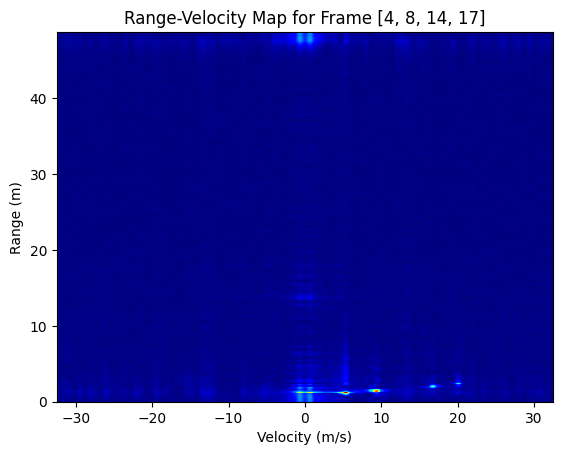

In [26]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
import random

# Define file path and parameters
fileFullPath_1 = r'D:\Drone-Swarm-Detection-with-AWR2243\Our data\Radar_Data\phantom_forward_2\slave3_0000_data.bin';
fileFullPath_2 = r'D:\Drone-Swarm-Detection-with-AWR2243\Our data\Radar_Data\phantom_forward_2\slave3_0000_data.bin';
fileFullPath_3 = r'D:\Drone-Swarm-Detection-with-AWR2243\Our data\Radar_Data\phantom_forward_2\slave3_0000_data.bin';
fileFullPath_4 = r'D:\Drone-Swarm-Detection-with-AWR2243\Our data\Radar_Data\phantom_forward_2\slave3_0000_data.bin';
file_paths=[fileFullPath_1,fileFullPath_2,fileFullPath_3,fileFullPath_4 ]
frameIdx = 50# Index of the frame to read
numSamplePerChirp = 256  # Number of samples per chirp
numChirpPerLoop = 12  # Number of chirps per loop
numLoops = 128 # Number of loops per frame
numRXPerDevice = 4  # Number of receiving channels per device
numDevices = 4  # Number of devices in the cascade (if needed)
# Create the filter for zero Doppler clutter removal
cutoff_freq =10  # Set cutoff frequency for the high-pass filter (Hz)
sampling_freq = 1000  # Sampling frequency (example value, should match your data)
def butter_highpass(cutoff, fs, order=6):
    """Design a Butterworth high-pass filter."""
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a
b, a = butter_highpass(cutoff_freq, sampling_freq)
# Function to read binary radar data
def readBinFile(fileFullPath, frameIdx, numSamplePerChirp, numChirpPerLoop, numLoops, numRXPerDevice):
    Expected_Num_SamplesPerFrame = numSamplePerChirp * numChirpPerLoop * numLoops * numRXPerDevice * 2
    with open(fileFullPath, 'rb') as fp:
        # Move to the desired frame in the file
        fp.seek((frameIdx - 1) * Expected_Num_SamplesPerFrame * 2)
        adcData1 = np.fromfile(fp, dtype=np.uint16, count=Expected_Num_SamplesPerFrame)

    # Convert the 16-bit data to signed integers
    neg = (adcData1 >> 15) == 1  # Check the sign bit
    adcData1 = adcData1.astype(np.int32)
    adcData1[neg] -= 2**16

    # Combine the I and Q channels into complex values
    adcData1 = adcData1[0::2] + 1j * adcData1[1::2]

    # Reshape and permute the data
    adcData1Complex = np.reshape(adcData1, (numRXPerDevice, numSamplePerChirp, numChirpPerLoop, numLoops), order='F')
    adcData1Complex = np.transpose(adcData1Complex, (1, 3, 0, 2))  # Permute dimensions
    return adcData1Complex
# Define the range of possible values
min_value = 4
max_value = 20

# Number of values in the list
num_values = 4

# Function to check if all values in the list have a minimum distance of 3
def has_minimum_distance(values, min_distance=3):
    # Check the distance between each pair of values
    return all(abs(values[i] - values[j]) >= min_distance for i in range(len(values)) for j in range(i + 1, len(values)))

# Generate up to 30 unique valid combinations
valid_combinations = set()

while len(valid_combinations) < 1:
    # Randomly select 4 values within the range
    candidate = random.sample(range(min_value, max_value + 1), num_values)
    
    # Check if the candidate list meets the minimum distance requirement
    if has_minimum_distance(candidate):
        # Convert the list to a tuple to ensure uniqueness in the set
        valid_combinations.add(tuple(candidate))

# Convert each tuple back to a list and print the results
for comb in valid_combinations:
    print(list(comb))
    #frame_num_list=list(comb)
    frame_num_list=[4,8,14,17]
    add_both_chirps_matrix = np.zeros((256, 128))

    for i in range(len(frame_num_list)):

        adcDataComplex= readBinFile(file_paths[i], frame_num_list[i], numSamplePerChirp, numChirpPerLoop, numLoops, numRXPerDevice)

        # Select antenna index and extract chirp ADC matrix
        # chirp_ADC_matrix = adcDataComplex[:, :, 3, :]
        # specific_transmitter_data = chirp_ADC_matrix[:, :, 0].T
        # if filter and b is not None and a is not None:
        #     specific_transmitter_data = filtfilt(b,a,specific_transmitter_data , axis=0)
        # chirps_matrix = specific_transmitter_data.T
        # specific_transmitter_data=np.transpose(specific_transmitter_data)
        # add_both_chirps_matrix=add_both_chirps_matrix+specific_transmitter_data
        chirp_ADC_matrix = adcDataComplex[:, :, 3, :]
        specific_transmitter_data = chirp_ADC_matrix[:, :, 0]
      
       
        add_both_chirps_matrix=add_both_chirps_matrix+specific_transmitter_data
        
    fc = 77e9
    c = 3e8
    sweepBandwidth = 0.89e9
    chirpDuration = 30e-6
   
    #specific_transmitter_data = filtfilt(b,a,  specific_transmitter_data , axis=0)
    if filter and b is not None and a is not None:
            add_both_chirps_matrix=np.transpose(add_both_chirps_matrix)
            add_both_chirps_matrix = filtfilt(b,a,add_both_chirps_matrix , axis=0)
            add_both_chirps_matrix=np.transpose(add_both_chirps_matrix)
            chirps_matrix = add_both_chirps_matrix

    # Define parameters
    slope = 29.9817e12
    chirp_duration = 30e-6
    c = 3e8  # Speed of light in m/s
    radar_data= chirps_matrix 
    # Assuming radar_data is already defined as a numpy array
    n_samples = radar_data.shape[1]  # Get number of samples per chirp
    n_chirps = radar_data.shape[0]  # Get number of chirps

    # Calculate the sample rate
    sample_rate = n_samples / chirp_duration

    # Create the time vector for range shift
    time = np.arange(n_samples) / sample_rate
    range_shift = 0

    # Calculate the frequency shift due to range shift
    frequency_shift_range = 2 * slope * range_shift / c

    # Calculate the phase shift for range shift
    phase_shift_range = 2 * np.pi * frequency_shift_range * time

    # Apply the range phase shift to radar data
    shifted_data_array = radar_data * np.exp(-1j * phase_shift_range)

    # Define velocity shift
    velocity_shift = 0

    # Create the time vector for velocity shift (column vector)
    time_velocity = np.arange(n_chirps) * chirp_duration

    # Calculate the frequency shift due to velocity shift
    frequency_shift_velocity = 2 * slope * velocity_shift / c

    # Calculate the phase shift for velocity shift
    phase_shift_velocity = 2 * np.pi * frequency_shift_velocity * time_velocity

    # Apply the velocity phase shift to the radar data
    shifted_data_array = shifted_data_array * np.exp(1j * phase_shift_velocity[:, np.newaxis])  # Broadcasting phase shift across samples


    Nfft_range = 290
    Nfft_doppler = 97

    range_fft = np.fft.fft(shifted_data_array, Nfft_range, axis=0)
    doppler_fft = np.fft.fftshift(np.fft.fft(range_fft, Nfft_doppler, axis=1), axes=1)
    


    range_res = c / (2 * sweepBandwidth)
    max_range = range_res * (Nfft_range - 1)
    range_axis = np.linspace(0, max_range, Nfft_range)

    velocity_res = (c / fc) / (2 * numLoops * chirpDuration * 12)
    max_velocity = (c / fc) / (chirpDuration * 4)
    velocity_axis = np.linspace(-max_velocity, max_velocity, Nfft_doppler)


    # # Plot the Range-Velocity map (absolute value of FFT)
    plt.figure()
    plt.imshow((np.abs(doppler_fft)), aspect='auto', extent=[velocity_axis[0], velocity_axis[-1], range_axis[0], range_axis[-1]], origin='lower',cmap='jet')
    #plt.imshow(20 * np.log10(np.abs(doppler_fft)), aspect='auto', extent=[velocity_axis[0], velocity_axis[-1], range_axis[0], range_axis[-1]], origin='lower',cmap='jet')
    plt.xlabel('Velocity (m/s)')
    plt.ylabel('Range (m)')
    plt.title(f'Range-Velocity Map for Frame {frame_num_list}')
    
        



In [27]:
print("Hello")

Hello


In [50]:
import random

# Define the range of possible values
min_value = 4
max_value = 20

# Number of values in the list
num_values = 4

# Function to check if all values in the list have a minimum distance of 3
def has_minimum_distance(values, min_distance=3):
    # Check the distance between each pair of values
    return all(abs(values[i] - values[j]) >= min_distance for i in range(len(values)) for j in range(i + 1, len(values)))

# Generate up to 30 unique valid combinations
valid_combinations = set()

while len(valid_combinations) < 30:
    # Randomly select 4 values within the range
    candidate = random.sample(range(min_value, max_value + 1), num_values)
    
    # Check if the candidate list meets the minimum distance requirement
    if has_minimum_distance(candidate):
        # Convert the list to a tuple to ensure uniqueness in the set
        valid_combinations.add(tuple(candidate))

# Convert each tuple back to a list and print the results
for comb in valid_combinations:
    print(list(comb))



[18, 5, 15, 10]
[11, 14, 20, 5]
[4, 17, 9, 12]
[4, 16, 19, 8]
[8, 11, 19, 16]
[20, 13, 5, 16]
[9, 6, 15, 18]
[4, 7, 10, 13]
[15, 12, 5, 18]
[18, 10, 13, 4]
[19, 11, 14, 5]
[4, 13, 7, 17]
[16, 5, 13, 8]
[19, 9, 16, 6]
[18, 13, 9, 5]
[11, 20, 7, 14]
[16, 20, 5, 9]
[5, 15, 12, 8]
[7, 4, 16, 13]
[10, 4, 20, 7]
[20, 17, 5, 10]
[7, 19, 4, 11]
[14, 5, 20, 8]
[20, 16, 10, 4]
[14, 10, 5, 18]
[9, 6, 12, 18]
[15, 11, 18, 5]
[17, 4, 12, 7]
[20, 13, 10, 7]
[15, 18, 4, 11]


[[5.24501603-1.24019934j 4.8859458 -0.98941722j 4.57671171-0.77344169j
  ... 6.79441172-2.32232955j 6.17476161-1.88955301j
  5.66799043-1.53561347j]
 [4.41596568+0.58951768j 4.06139046+0.67060286j 3.75631549+0.73998864j
  ... 5.94841104+0.2358506j  5.33519035+0.37783337j
  4.83398986+0.49346842j]
 [2.53664313+1.33602608j 2.30382347+1.29725433j 2.10412428+1.26329053j
  ... 3.5481179 +1.49845833j 3.14261919+1.43419259j
  2.81186404+1.38101176j]
 ...
 [0.92292876-3.73728178j 0.98206984-3.43468085j 1.03406806-3.17330482j
  ... 0.67678249-5.03643992j 0.77393059-4.51780652j
  0.85453785-4.09281063j]
 [2.8567101 -4.14129455j 2.77881407-3.74332481j 2.71225815-3.39975339j
  ... 3.19732364-5.85143593j 3.06046023-5.16851441j
  2.9491024 -4.60908966j]
 [4.60446607-3.14981881j 4.35796793-2.77143157j 4.14577904-2.44504012j
  ... 5.66893665-4.77813959j 5.2431047 -4.12755783j
  4.89495021-3.59492386j]]


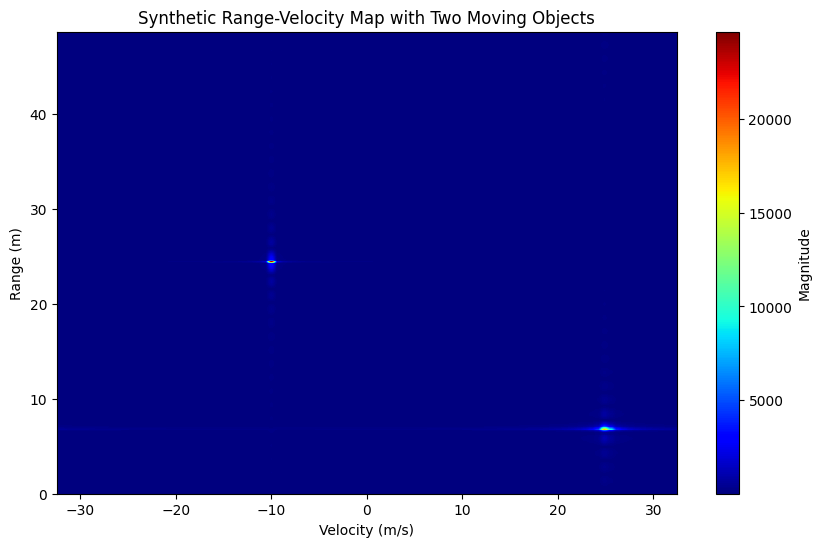

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters for synthetic data
numSamplePerChirp = 256  # Number of samples per chirp
numChirpPerLoop = 12  # Number of chirps per loop
numLoops = 128  # Number of loops per frame

# Radar parameters
fc = 77e9  # Carrier frequency (Hz)
c = 3e8  # Speed of light (m/s)
sweepBandwidth = 0.89e9  # Sweep bandwidth (Hz)
chirpDuration = 30e-6  # Duration of each chirp (seconds)
Nfft_range = 290  # FFT points for range calculation
Nfft_doppler = 97  # FFT points for Doppler calculation

# Generate synthetic signal with two objects
# Object 1: Closer, slower
range1 =50000*4# meters
velocity1 = 50  # m/s

# Object 2: Further, faster
range2 = 40000000000 # meters
velocity2 = -20 # m/s

# Generate synthetic chirp returns for both objects
t = np.arange(numSamplePerChirp) * chirpDuration / numSamplePerChirp

# Initialize the chirps matrix to store the returns for all loops
chirps_matrix = np.zeros((numSamplePerChirp, numLoops), dtype=complex)

# Populate the chirps matrix with returns for both objects
for loop_idx in range(numLoops):
    # Create returns for each object
    object1 = np.exp(1j * 2 * np.pi * (2 * range1 * sweepBandwidth / c) * t)
    object1 *= np.exp(1j * 2 * np.pi * velocity1 * loop_idx * chirpDuration * fc / c)
    
    object2 = np.exp(1j * 2 * np.pi * (2 * range2 * sweepBandwidth / c) * t)
    object2 *= np.exp(1j * 2 * np.pi * velocity2 * loop_idx * chirpDuration * fc / c)
    
    # Combine the returns and store in the matrix
    chirps_matrix[:, loop_idx] = object1 + object2

# Perform range FFT
range_fft = np.fft.fft(chirps_matrix, Nfft_range, axis=0)

# Perform Doppler FFT
doppler_fft = np.fft.fftshift(np.fft.fft(range_fft, Nfft_doppler, axis=1), axes=1)
print(doppler_fft )


# Calculate range and velocity axes
range_res = c / (2 * sweepBandwidth)
max_range = range_res * (Nfft_range - 1)
range_axis = np.linspace(0, max_range, Nfft_range)

velocity_res = (c / fc) / (2 * numLoops * chirpDuration * numChirpPerLoop)
max_velocity = (c / fc) / (chirpDuration * 4)
velocity_axis = np.linspace(-max_velocity, max_velocity, Nfft_doppler)

# Plot the Range-Velocity map (absolute value of FFT)
plt.figure(figsize=(10, 6))
plt.imshow(np.abs(doppler_fft), aspect='auto', extent=[velocity_axis[0], velocity_axis[-1], range_axis[0], range_axis[-1]], origin='lower', cmap='jet')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Range (m)')
plt.title('Synthetic Range-Velocity Map with Two Moving Objects')
plt.colorbar(label='Magnitude')
plt.show()
